# Проект: вариант 2
## Задание 1. A/B–тестирование

### 1.1 Условие

- Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### 1.2 Входные данные

**В качестве входных данных Вы имеете 4 csv-файла:**

- groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
- groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
- active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
- checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

### 1.3 Вопросы

**Предлагаем Вам ответить на следующие вопросы:**

- 1.На какие метрики Вы смотрите в ходе анализа и почему?
- 2.Имеются ли различия в показателях и с чем они могут быть связаны?
- 3.Являются ли эти различия статистически значимыми?
- 4.Стоит ли запускать новую механику на всех пользователей?
Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

### 1.4 Требования к ответу

###### При выполнении тестового задания необходимо использовать язык программирования Python. 
###### В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными. 
###### Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.

## Импортируем нужные библиотеки 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandahouse as ph
from scipy.stats import bootstrap

## Считаем данные

In [2]:
groups = pd.read_csv('Проект_2_groups.csv', sep=';')
groups_add = pd.read_csv('Проект_2_group_add.csv')
active_studs = pd.read_csv('Проект_2_active_studs.csv')
checks = pd.read_csv('Проект_2_checks.csv', sep=';')

## Проверим данные

# 1.GROUPS

In [3]:
groups.info()
# Нулевых значений нет.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [4]:
groups = groups.rename(columns={'grp': 'group'})
groups.head()

,id,group
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


**Посмотрим количество пользователей в контрольной и целевой группах.**

<b> А - контрольная (базовая механика оплаты услуг на сайте)<b/>
    
<b>B - целевая (новая механика оплаты услуг на сайте)<b/>

In [5]:
group_distribution_users = groups.groupby('group', as_index=False) \
                                 .agg({'id': 'count'}) \
                                 .rename(columns={'id': "count_users"})

In [6]:
group_distribution_users['percent'] = (group_distribution_users.count_users / groups.shape[0] * 100).round(1)
group_distribution_users.head()
# Видно, что количество пользователей в группах сильно различаются.

,group,count_users,percent
0,A,14671,19.7
1,B,59813,80.3


In [7]:
groups.id.nunique()
# Все пользователи уникальны, повторений нет.

74484

# 2.GROUPS_ADD

In [8]:
groups_add.info()
# Нулевых значений нет.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [9]:
groups_add = groups_add.rename(columns={'grp': 'group'})
groups_add.head()

,id,group
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


**Посмотрим количество пользователей в контрольной и целевой группах спустя 2 дня после передачи данных.**

<b> А - контрольная (базовая механика оплаты услуг на сайте)<b/>
    
<b> B - целевая (новая механика оплаты услуг на сайте)<b/>

In [10]:
groups_add_distribution_users = groups_add.groupby('group', as_index=False) \
                                          .agg({'id': 'count'})

In [11]:
groups_add_distribution_users['percent'] = (groups_add_distribution_users.id / groups_add.shape[0] * 100).round(1)
groups_add_distribution_users.head()
# Видно, что количество пользователей в группах сильно различаются.

,group,id,percent
0,A,22,23.9
1,B,70,76.1


In [12]:
groups_add.id.nunique()
# Все пользователи уникальны, повторений нет.

92

In [13]:
groups.merge(groups_add, on='id')
# Видим, что пользователей, которых нам присали спустя 2 дня после передачи данных нет в исходных данных. 

,id,group_x,group_y


#### Мы можем объединить 2 таблицы пользователей и в дальнейшем использовать новый датафрейм.

In [14]:
all_groups = pd.concat([groups, groups_add], ignore_index=True)
all_groups.shape[0]
# На выходе получаем 74576 уникальных пользователей.

74576

# 3.ACTIVE_STUDS

In [15]:
active_studs.info()
# Нулевых значений нет.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [16]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [17]:
active_studs.student_id.nunique()
# Все пользователи уникальны, повторений нет.

8341

In [18]:
active_studs = active_studs.rename(columns={'student_id': 'id'})
# Для удобства переименуем колонку.

In [19]:
active_studs['activity_users'] = '1'
# обозначим активным пользователей единичкой.

In [20]:
active_studs.head()

,id,activity_users
0,581585,1
1,5723133,1
2,3276743,1
3,4238589,1
4,4475369,1


#### Объединим таблицы, чтобы увидеть распределение зашедших на сайт пользователей по группам.

In [21]:
active_users = all_groups.merge(active_studs, on='id')

In [22]:
distribution_active_users = active_users.groupby('group', as_index=False) \
                                        .agg({'id': 'count'})

In [23]:
distribution_active_users['percent'] = (distribution_active_users.id / active_users.shape[0] * 100).round(1)
distribution_active_users.head()
# Видно, что количество пользователей в группах сильно различаются.

,group,id,percent
0,A,1538,18.4
1,B,6803,81.6


# 4.CHECKS

In [24]:
checks.info()
# Нулевых значений нет.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [25]:
checks['paid_users'] = '1'
# Обозначим активных пользователей единичкой.

In [26]:
checks.head()

,student_id,rev,paid_users
0,1627,990.0,1
1,3185,690.0,1
2,25973,690.0,1
3,26280,690.0,1
4,100300,990.0,1


In [27]:
checks.student_id.nunique()
# Все пользователи уникальны, повторений нет.

541

In [28]:
checks = checks.rename(columns={'student_id': 'id', 'rev': 'order_price'})
# Для удобства переименуем колонки.

#### Топ-5 цен по количеству оплативших пользователей.

In [29]:
top_checks = checks.groupby('order_price', as_index=False) \
                   .agg({'id': 'count'}) \
                   .sort_values('id', ascending=False) \
                   .head(5)
top_checks.head()
# Возможно стоит обрать внимание именно на эти суммы.

,order_price,id
24,1900.0,97
1,290.0,94
8,690.0,78
0,199.0,46
13,990.0,41


In [30]:
count_orders_price = checks.merge(all_groups, on='id') \
                           .groupby('group', as_index=False) \
                           .agg({'order_price': 'count'})

In [31]:
count_orders_price['percent'] = (count_orders_price.order_price / checks.shape[0] * 100).round(1)
count_orders_price.head()
# Количество пользователей, совершивших оплату в группе А намного меньше, что логично, исходя из предыдущих данных.

,group,order_price,percent
0,A,107,19.8
1,B,434,80.2


### Для простоты работы объединим все данные в одну таблицу и обозначим пользователей:
- 1. Пользователи зашли/не зашли на сайт в дни проведения эксперимента.
- 2. Пользователи совершили оплату/не совершили оплату в дни проведения эксперимента (будет понятно по сумме покупки).

In [32]:
full_info_df = all_groups.merge(checks, on='id', how='left').fillna(0) \
                         .merge(active_studs, on='id', how='left', ).fillna('0') 
                         
full_info_df.head()

,id,group,order_price,paid_users,activity_users
0,1489,B,0.0,0,0
1,1627,A,990.0,1,1
2,1768,B,0.0,0,0
3,1783,B,0.0,0,0
4,1794,A,0.0,0,0


In [33]:
percent_inactive_users = full_info_df.query('activity_users == "0"') \
                                     .order_price.sum() / full_info_df.order_price.sum() * 100
percent_inactive_users.round(1)

18.4

Видим, что неактивные пользователи (не заходили на сайт в дни эксперимента) совершили __18,4% покупок от общей суммы.__

In [34]:
full_info_df.query('activity_users == "0" and order_price != 0') \
            .groupby('order_price', as_index=False) \
            .agg({'id': 'count'}) \
            .sort_values('id', ascending=False)

,order_price,id
5,690.0000,61
1,290.0000,24
7,990.0000,19
0,199.0000,14
8,1140.0000,14
3,580.0000,4
10,1900.0000,4
6,840.0000,3
2,398.0000,2
4,630.0000,1


Так как суммы по списаниям разные, то скорее всего она зависит от количества дней использования платформы пользователем до момента списания. 

In [35]:
full_info_df.query('activity_users == "1" and order_price != 0') \
            .groupby('group', as_index=False) \
            .agg({'order_price': 'count'})

,group,order_price
0,A,78
1,B,314


Из __541__ пользователя совершивших оплату __392__ активных пользователя, заходивших во время эксперимента на платформу. 

### Нам интересны активные пользователи, совершившие оплату (__392 пользователя__). Основной датафрейм будет __full_activity_df.__

In [36]:
full_activity_df = full_info_df.query('order_price > 0 and activity_users == "1"')
full_activity_df.head()

,id,group,order_price,paid_users,activity_users
1,1627,A,990.0000,1,1
220,100300,B,990.0000,1,1
320,108270,B,290.0000,1,1
3779,264473,B,1900.0001,1,1
4187,274352,B,690.0000,1,1


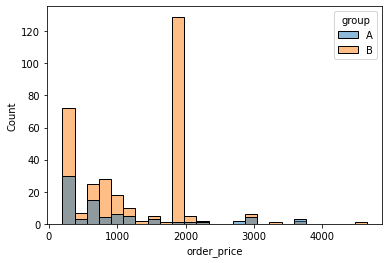

In [37]:
sns.histplot(data=full_activity_df, x='order_price', hue='group', bins=25)
# Хорошо видно преобладание пользователей из целевой группы.

In [38]:
full_activity_df.order_price.sum()

467794.0035

In [39]:
full_activity_info = full_activity_df.groupby('group', as_index=False) \
                                     .agg({'order_price': 'sum', 'id': 'count'})
full_activity_info

,group,order_price,id
0,A,72820.0000,78
1,B,394974.0035,314


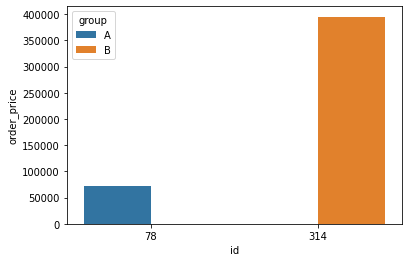

In [40]:
sns.barplot(data=full_activity_info, x='id', y='order_price', hue='group')

##### При обработке данных и предварительном анализе было выяснено:
- Во всех трёх датафреймах (groups, groups_add, active_studs) процентное соотношение пользователей в группах А и B примерно одинаковое. Стоит заметить, что в контрольной группе количество пользователей намного меньше и примерно составляет __20%__. Общее количество уникальных пользователей - __74576__ (датафрейм all_groups). Активных пользователей, которые зашли на платформу в дни проведения эксперимента - __8341__.  
  
- Количество пользователей, которые совершили оплату в дни проведения эксперимента - __541__. Наибольшее количество пользователей совершили оплату на сумму __1900р.__ Но __149__ пользователей, совершивших оплату, не захоидили на платформу во время проведения эксперимента. Эти пользователи совершили __18,4%__ покупок от общей стоимости. Так как дополнительной информации нет, то причины могут быть разными, например классические списания за какой-то период времени (месяц, квартал и т.п.), ошибка при прохождении платежа, сбой в данных. Также видно, что суммы списания у этих пользователей разные. Выделяется сумма __1900.0001__, что выглядит как какой-то сбой. Так как истинная причина неизвестна принял решение убрать эти данные из датафрейма. 
  
- Перед выбром метрик имеем датафрейм full_activity_info, в котором:
  1. Общая сумма оплат составляет __467794.0035__  (группа A - 72820.0, группа B - 394974.0035).
  2. Количество уникальных пользователей во время проведения эксперимента __392__  (группа A - 78, группа B - 314).

## Выбор метрик:

Основная цель: увеличить доход с помощью новой механики оплаты,для этого нужно привлечь пользователей (например качеством продукта, красивой и понятной платформой, надёжностью и простотой оплаты). __СR__ покажет изменилось ли количество пользователей, совершивших оплату благодаря новой механике оплаты (возможно стало проще производить оплату, поэтому число оплат увеличилось). __ARPU и ARPPU__ покажет увеличился ли доход с активного/активного платящего пользователя.
 - __ARPU__ (средний доход с привлеченного пользователя).
 - __ARPPU__ (средний доход с платящего пользователя).
 - __СR__ (коэффициент, показывающий  отношение количества активных пользователей, совершивших оплату, к общему числу пользователей, которые зашли на платформу в дни проведения эксперимента)
 
 Сначала можно проверить это вычислениями,а потом проверить статистическими методами.

### 1. CR

CR = Кол-во оплативших польз-ей/ Кол-во польз-ей,заходивших на платформу во время эксперимента.

In [41]:
CR_A_group = (full_activity_info.id[0] / active_users.query('group == "A"')
                                                     .shape[0]).round(4)
CR_A_group

0.0507

In [42]:
CR_B_group = (full_activity_info.id[1] / active_users.query('group == "B"')
                                                     .shape[0]).round(4)
CR_B_group

0.0462

### 2.ARPPU

ARPPU = Доход / Число клиентов

In [43]:
ARPPU_A_group = (full_activity_info.order_price[0] / full_activity_info.id[0]).round(2)
ARPPU_A_group

933.59

In [44]:
ARPPU_B_group = (full_activity_info.order_price[1] / full_activity_info.id[1]).round(2)
ARPPU_B_group

1257.88

### 3.ARPU

ARPU = CR * ARPPU 

Тут конверсию рассчитываем уже на всех активных пользователей.

In [45]:
ARPU_A_group = full_activity_info.id[0] / active_users.query('group == "A"').shape[0] * ARPPU_A_group
ARPU_A_group.round(2)

47.35

In [46]:
ARPU_B_group = full_activity_info.id[1] / active_users.query('group == "B"').shape[0] * ARPPU_B_group
ARPU_B_group.round(2)

58.06

Видим, что у контрольной группы конверсия больше на __8,8%__,а у целевой группы больше ARPU (на __22,6%__) и ARPPU (на __33%__). Показатели доходов лучше у новой механики оплаты, но не стоит забывать, что размеры групп разные. Это влияет на кол-во пользователей и соответсвенно на метрики.

### Проверим наши группы на нормальность распределения (так как группы не совпадают по размерам) и на гамогенность дисперсии, чтобы начать отталкиваться для выбора необходимого теста.

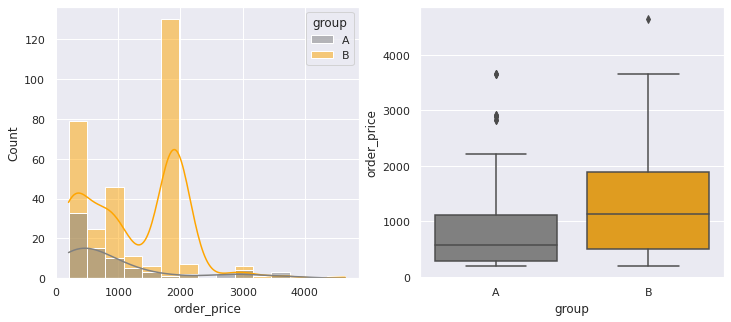

In [47]:
sns.set(rc={'figure.figsize': (12, 5)})
fig, ax = plt.subplots(1, 2)

sns.set_palette(['grey', 'orange'])
sns.histplot(x=full_activity_df.order_price, hue=full_activity_df.group, kde=True, ax=ax[0], bins=15)
sns.boxplot(data=full_activity_df, y='order_price', x='group', ax=ax[1])

Судя по графику слева группы не имеют нормального распределения (они ассиметричные, есть несколько мод). Выбросы присутствуют в обеих группах, но группы как я считаю небольшие, чтобы это принимать во внимание. Cам прямоугольник целевой группы больше, а его "усы' охватывают более широкий диапазон. Но проблема ящика с усами в том, что он скрывает форму данных и сообщает некоторую сводную статистику, но не показывает фактическое распределение данных.

#### Тесты для проверки нормальности распределения:

- Тест Колмогорова-Смирнова
- Тест Шапиро-Уилка 

 __H0__ - распределение соответствует нормальному.
 __H1__ - распределение отклоняется от нормального.
 р-уровень значимости 0.05.

In [48]:
if stats.shapiro(full_activity_df.query('group == "B"').order_price)[1] < 0.05:
    print("Распределение отклоняется от нормального")
else:
    print("Распределение соответствует нормальному")
# Для группы B.

Распределение отклоняется от нормального


Для уверенности применим Тест Колмогорова-Смирнова.

In [49]:
stats.kstest(full_activity_df.query('group == "A"').order_price, 'norm')


KstestResult(statistic=1.0, pvalue=0.0)

In [50]:
stats.kstest(full_activity_df.query('group == "B"').order_price, 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

В обоих случаях значения меньше выбранного p-value=0,05, значит отвергаем нулевую гипотезу, соответственно распределения групп отклоняются от нормального.

#### Теперь проверим группы на гомогенность дисперсии. Для этого применим тест Левена.

 - __H0__ - дисперсия среди групп одинакова.
 - __H1__ - дисперсия среди групп не одинакова.
 - р-уровень значимости 0.05.

In [51]:
stats.levene(full_activity_df.query('group == "A"').order_price,
             full_activity_df.query('group == "B"').order_price, center='median')

LeveneResult(statistic=3.075681699981606, pvalue=0.08025675761347022)

Так как p-value>0.05 можем принимать нулевую гипотезу и говорить о том, что дисперсии групп одинаковы.

### Выбор теста:
1) Распределение групп отклоняется от нормального, сами группы небольшие, что говорит о том,что t-test использовать не нужно. На практике t-тест может быть использован для сравнения средних и при ненормальном распределении, особенно на больших выборках и если в данных нет заметных выбросов, однако это очень опасно и для этого нужен более детальный анализ. Можно было бы прологорфимировать данные, посмотреть на нормальность распределении и применить t-test к исходным данным. Но всё таки я решил не использовать этот вариант. 

2) Если распределение признака отличается от нормального, можно использовать непараметрический аналог – U-критерий Манна-Уитни. Этот критерий менее чувствителен к экстремальным отклонениям от нормальности и наличию выбросов. Однако этот критерий не сравнивает средние - он проверяет, что вероятность случайно взять из первой группы более высокое значение, чем из второй, равна 50%. Соответственно, если вероятность не равна 50%, то в какой-то из выборок более высокие значения встречаются чаще. Этот тест не подходит под мою гипотезу.

3) Для CR я буду использовать Хи-квадрат Пирсона. Для ARPU и ARPPU адекватнее всего выглядит бутстрап, его и применю.
   

### 1.CR

 - __H0__ - различия в CR между пользователями группы А и группы В отсутствуют.
 - __H1__ - различия в CR между пользователями группы А и группы В присутствуют.
   
 р-уровень значимости 0.05.

In [52]:
full_info_df = full_info_df.query('activity_users == "1"')
full_info_df.head()
# Отфильтруем только тех пользователей, которые заходили во время эксперемента на платформу.

,id,group,order_price,paid_users,activity_users
1,1627,A,990.0,1,1
10,2085,B,0.0,0,1
12,2215,B,0.0,0,1
43,3391,A,0.0,0,1
45,3401,B,0.0,0,1


In [53]:
chi_squared_crosstab = pd.crosstab(full_info_df.group, full_info_df.paid_users)
chi_squared_crosstab
# Сделаем таблицу сопряжённости.

paid_users,0,1
group,,
A,1460,78
B,6489,314


In [54]:
chi_squared = stats.chi2_contingency(chi_squared_crosstab)[1].round(3)
chi_squared

0.486

Так как p-value больше 0,05 нельзя отклонить нулевую гипотезу. В начальных расчётах конверсия новой механики уменьшилась, однако тест показал, что статистически значимых различий в CR между пользователями группы А и группы В нет.

### 2.ARPU

 - __H0__ - ARPU группы А и группы В не различаются.
 - __H1__ - ARPU группы А и группы В различаются.

In [55]:
# Выделим активных польз-ей по группам.
group_A_ARPU = full_info_df.query('group == "A" and activity_users == "1"')
group_B_ARPU = full_info_df.query('group == "B" and activity_users == "1"')

In [56]:
# Запишем функцию бутстрап.
def function (df_1, df_2):
    return np.mean(df_1) - np.mean(df_2)

In [57]:
# Расчёт средних значений для ARPU
arpu_result = stats.bootstrap((group_A_ARPU.order_price, group_B_ARPU.order_price),
                              statistic=function,
                              n_resamples=1000,
                              vectorized=False,
                              method='basic')

In [58]:
# Уже видим, что 0 попадает в доверительный интервал.
confidential_interval = (arpu_result.confidence_interval[0],
                         arpu_result.confidence_interval[1])
confidential_interval

(-27.333983798371566, 5.598399520185083)

Тест не показал статистически значимые отличия ARPU между группами А и В, так как ноль входит в доверительный интервал. Мы не можем отвергнуть нулевую гипотезу, соответственно принимаем альтернативную (ARPU в группах статистически значимо не различается).

### 3.ARPPU

 - __H0__ - ARPPU группы А и группы В не различаются.
 - __H1__ - ARPPU группы А и группы В различаются.

In [59]:
# Выделим активных польз-ей по группам.
group_A_ARPPU = full_activity_df.query('group == "A"')
group_B_ARPPU = full_activity_df.query('group == "B"')

In [65]:
# Расчёт средних значений для ARPPU
arppu_result = stats.bootstrap((group_A_ARPPU.order_price, group_B_ARPPU.order_price),
                               statistic=function,
                               n_resamples=1000,
                               vectorized=False,
                               method='basic')

In [67]:
# Уже видим, что 0 непопадает в доверительный интервал.
confidential_interval = (arppu_result.confidence_interval[0],
                         arppu_result.confidence_interval[1])
confidential_interval

(-551.3473632827042, -98.16869922362378)

Тест показал статистически значимые отличия ARPPU между группами А и В, так как ноль не входит в доверительный интервал. Мы можем отвергнуть нулевую гипотезу и принять альтернативную (ARPPU в группах статистически значимо различается).

## Выводы:
    
   Изначально плохо сделано сплитование, группы разбиты в среднем 20 на 80, что не корректно для исследований. Если говорить о самой фиче новой механики оплаты, то с большой долей вероятности это связано с суммой 1900р, т.к. 30% плативших пользователей из тестовой группы  совершили именно этот платёж. Также были непонятные данные в виде 1900.001 - этот вопрос отсаётся открытым. 
   
   Метод Хи-квадрат для CR не показал статистически значимых различий, как и бутстрап для ARPU, однако после проведения теста методом бутстрап ARPPU  показал статистически значимые различия. Так как в задаче нужен ответ, то я считаю, что запускать новую механику оплаты на всех пользователей стоит. Однако в реальных условиях я бы переделал систему сплитования, разобрался бы с неактивными пользователями, которые проводили платёж, запросил бы данные, связанные с временем проведения эксперимента, а потом бы проводил тесты и делал бы выводы.

# Задание 2. SQL
### 2.1 Очень усердные ученики.

### 2.1.1 Условие

- Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

- Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

### 2.1.2 Задача

- Дана таблица default.peas:
- Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

### 2.2 Оптимизация воронки

### 2.2.1 Условие

- Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

### 2.2.2 Задача

- Дана таблицы: default.peas (см. выше), default.studs:
- Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
- ARPU считается относительно всех пользователей, попавших в группы.

##### Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

##### Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

##### Все данные находятся в табличном виде в ClickHouse

# 2.1.2

In [72]:
connection_database = 

In [73]:
# Проверю или данные подтягиваются корректно.
test_df = """
          SELECT
              st_id, 
              toDateTime(timest) as timest,
              correct, 
              subject
          FROM 
              peas
          """

# Отправляем запрос и записываем результат в пандасовский датафрейм.
test_df = ph.read_clickhouse(query=test_df, connection=connection_database)
test_df.head()

,st_id,timest,correct,subject
0,100379,2021-10-30 13:32:29,1,Theory of probability
1,100379,2021-10-30 14:11:19,0,Vizualization
2,100379,2021-10-30 15:54:22,1,Theory of probability
3,100379,2021-10-30 16:44:50,1,Vizualization
4,100379,2021-10-30 17:15:05,1,Theory of probability


In [74]:
print(f'Количество уникальных предметов: {test_df.subject.nunique()}')
print(f'Количество уникальных студентов: {test_df.st_id.nunique()}')
print(f'Количество правильно решенных горошин: {test_df.query("correct == 0").st_id.count()}')
print(f'Количество неправильно решенных горошин: {test_df.query("correct == 1").st_id.count()}')

Количество уникальных предметов: 5
Количество уникальных студентов: 308
Количество правильно решенных горошин: 6481
Количество неправильно решенных горошин: 6764


In [75]:
# Посмотрим диапазон времи решения карточки.

delta_time = """
SELECT 
    min(toDateTime(timest)) as min_time,
    max(toDateTime(timest)) as max_time
FROM 
    peas
"""

# Отправляем запрос и записываем результат в пандасовский датафрейм.
delta_time = ph.read_clickhouse(query=delta_time, connection=connection_database)
delta_time.head()

,min_time,max_time
0,2021-10-30 13:00:00,2021-10-31 17:29:52


Временной диапазон небольшой, чуть больше суток.

In [76]:
result_task1 = ''' 
    SELECT 
        COUNT(Distinct st_id) as count_success_id 
    FROM
        (
        SELECT 
            st_id,
            COUNT(correct) as sum_correct
        FROM 
            default.peas
        WHERE correct = 1
        GROUP BY st_id
        HAVING sum_correct >= 20
        )
    '''

# Отправляем запрос и записываем результат в пандасовский датафрейм.
result_task1 = ph.read_clickhouse(query=result_task1, connection=connection_database)
result_task1.head()

,count_success_id
0,136


__Ответ:__ За данный период времени найдено 136 усердных студентов.

# 2.2.2

In [79]:
task2 = '''
        SELECT 
            test_grp as group,
            round(SUM(f.money) / uniqExact(s.st_id), 2) as ARPU, 
            round(SUMIf(f.money, p.active > 10) / uniqIf(s.st_id,  p.active > 10), 2) as ARPAU,
            round(uniqIf(s.st_id, f.money > 0) / uniqExact(s.st_id) * 100, 2) AS CR,
            round(uniqIf(s.st_id, f.money > 0 and p.active > 10) / uniqIf(s.st_id, p.active > 10)* 100, 2) 
                                                                                                      AS CR_Active,
            round(uniqIf(s.st_id, f.money > 0 and p.math_active >= 2 and f.subject = 'Math') / 
                                                        uniqIf(s.st_id, p.math_active >= 2) * 100, 2) AS CR_math

        FROM
            studs as s
        LEFT JOIN 
            final_project_check as f
            ON s.st_id = f.st_id
        LEFT JOIN (SELECT 
                        st_id, 
                        SUM(correct) as active, 
                        SUMIf(correct, subject = 'Math') as math_active
                    FROM 
                        peas
                    GROUP BY 
                        st_id
                        ) as p 
        ON s.st_id = p.st_id

        GROUP BY test_grp

'''
# отправляем запрос и записываем результат в пандасовский датафрейм
task2 = ph.read_clickhouse(query=task2, connection=connection_database)
task2

,group,ARPU,ARPAU,CR,CR_Active,CR_math
0,control,4540.98,10393.70,4.92,11.02,6.12
1,pilot,11508.47,29739.58,10.85,26.04,9.52


# Задание 3. Python
### 3.1 Задача

- Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
- Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [80]:
def func_for_metrics(groups, groups_add, active_studs, checks):
    
    active_studs['activity'] = 1
    checks['is_paid'] = 1
       
    all_groups = pd.concat([groups, groups_add]).rename(columns={'grp': 'group'})
    full_info_df = all_groups.merge(checks, on='id', how='left').fillna(0) \
                             .merge(active_studs, on='id', how='left').fillna(0) 
    
    function = full_info_df.query('activity == 1')
    metrics = function.groupby('group', as_index=False) \
                      .agg({'id': 'count', 'is_paid': ['sum', 'mean'], 'order_price': ['sum', 'mean']}) 
    
    metrics.columns = ['group', 'students', 'checks', 'CR', 'order_price', 'ARPPU']
    metrics['CR'] = round(metrics['CR'] * 100, 1)
    metrics['ARPPU'] = round(metrics['order_price'] / metrics['checks'], 1)
    metrics['ARPU'] = round(metrics['order_price'] / metrics['students'], 1)    
    
    return metrics
            
    '''
    Для удобства обозначим новые столбцы для активных и платящих пользователей, далее мержим все таблицы, 
    чтобы вывести все данные в единую таблицу.
    Фильтруем только активных польз-ей, после этого считаем метрики.
    '''   

In [81]:
result_func = func_for_metrics(groups, groups_add, active_studs, checks)
result_func

,group,students,checks,CR,order_price,ARPPU,ARPU
0,A,1538,78.0,5.1,72820.0000,933.6,47.3
1,B,6803,314.0,4.6,394974.0035,1257.9,58.1


In [82]:
def func_for_metrics_vizual(result_func):
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

    ax[0].bar(result_func.group, result_func.ARPU, color=['grey', 'orange'], alpha=0.6)
    ax[0].set_title('ARPU')
    ax[0].tick_params(axis='both', labelsize=18)

    ax[1].bar(result_func.group, result_func.ARPPU, color=['grey', 'orange'], alpha=0.6)
    ax[1].set_title('ARPPU')
    ax[1].tick_params(axis='both', labelsize=18)

    ax[2].bar(result_func.group, result_func.CR, color=['grey', 'orange'], alpha=0.6)
    ax[2].set_title('CR')
    ax[2].tick_params(axis='both', labelsize=18)

    plt.show()

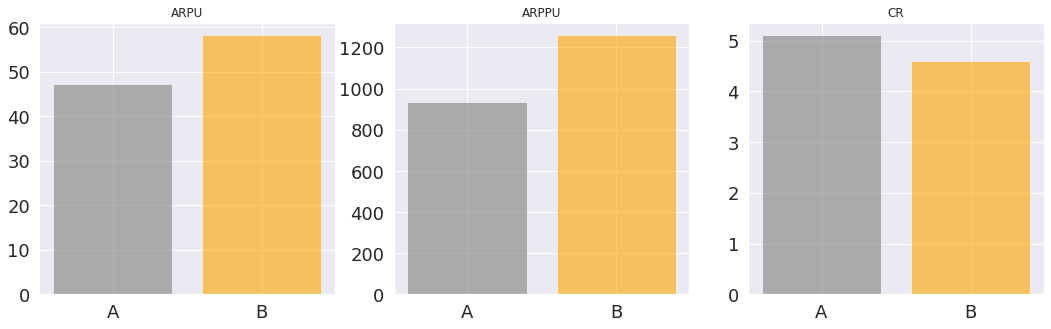

In [83]:
func_for_metrics_vizual(result_func) 